In [98]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from ipywidgets import FloatSlider
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.optimize import curve_fit

plt.style.use("ggplot")
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 13

In [3]:
!cat farmakoloski.dat

#x[doza]	y[odziv]
1       0.0001
2	0.001
7	15.3
10	34.6
20	49.3
70	82.6
200	96.0
1000	100.0


In [46]:
data = pd.read_table("farmakoloski.dat", sep="\t" , skiprows=1,
                     names=["x", "y"],dtype = np.float64)
data["v"] = data.y**(-1)
data["y_err"] = 3
data["v_err"] = data.y_err/data.y**2
data.head()

,x,y,v,y_err,v_err
0,1.0,0.0001,10000.000000,3,3.000000e+08
1,2.0,0.0010,1000.000000,3,3.000000e+06
2,7.0,15.3000,0.065359,3,1.281558e-02
3,10.0,34.6000,0.028902,3,2.505931e-03
4,20.0,49.3000,0.020284,3,1.234319e-03


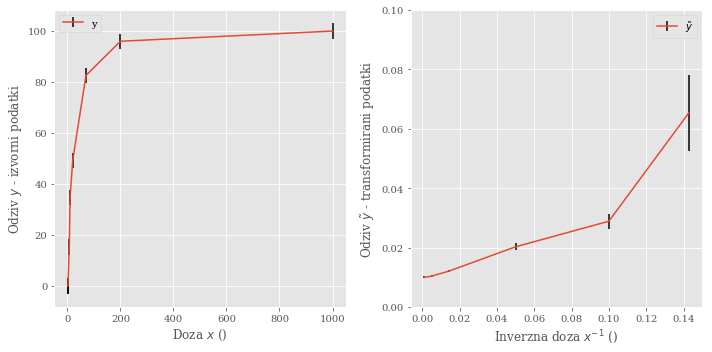

In [44]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.errorbar(data.x, data.y, yerr=data.y_err, label="y", ecolor="k")
plt.xlabel(r"Doza $x$ ()")
plt.ylabel(r"Odziv $y$ - izvorni podatki")
plt.legend()

plt.subplot(122)
plt.errorbar(1/data.x[2:], data.v[2:], yerr = data.v_err[2:], label=r"$\tilde{y}$", ecolor="k")
plt.xlabel(r"Inverzna doza $x^{-1}$ ()")
plt.ylabel(r"Odziv $\tilde{y}$ - transformirani podatki")
plt.legend()
plt.ylim((0, 1e-1))

plt.tight_layout(h_pad=1.05)
plt.savefig("1-1-original-in-transformirano.pdf")
plt.savefig("1-1-original-in-transformirano.jpg")
plt.show()

In [70]:
def fi1(x):
    """Prva bazna funkcija"""
    return 1
def fi2(x):
    """Druga bazna funkcija"""
    return np.power(x, -1)

fiji = [fi1, fi2]

A = np.zeros((2,2))
for j in [0,1]:
    for k in [0,1]:
        A[j, k] = sum( fiji[j](data.x) * fiji[k](data.x)/(data.v_err**2)        )
b = np.zeros((2,))
for j in [0,1]:
    b[j] = sum(data.v*fiji[j](data.x)/data.v_err**2)


SyntaxError: can't use starred expression here (cell_name, line 20)

In [74]:
from numpy.linalg import inv
a = np.dot(inv(A), b)
a

array([0.00955264, 0.20241427])

In [76]:
hi2 = sum((data.v - a[0]*fi1(data.x)-a[1]*fi2(data.x))**2 /data.v_err**2)
hi2

6.237709441348021

In [77]:
len(data.x) - 2

6

In [52]:
%timeit sum(data.x)

61 µs ± 8.95 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [53]:
%timeit np.sum(data.x)

314 µs ± 38.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [59]:
np.zeros((2,))

array([0., 0.])

In [82]:
a

array([0.00955264, 0.20241427])

In [96]:
C = inv(A)
C

array([[ 5.14135815e-08, -2.00568648e-06],
       [-2.00568648e-06,  2.92826399e-04]])

In [94]:
D=np.zeros((2,2))
np.fill_diagonal(D, np.diag(C))
D = np.sqrt(D)
rho = inv(D) @ C @ inv(D)
rho

array([[ 1.        , -0.51691484],
       [-0.51691484,  1.        ]])

In [95]:
len(data)

8

In [102]:
def model(x, y0, a):
    return (y0 * x)/(x+a)

popt, pcov = curve_fit(model, data.x, data.y, sigma=data.y_err
                      )
popt


array([106.31712844,  24.76258099])

In [100]:
pcov

array([[22.64732839, 13.22026102],
       [13.22026102, 17.33688045]])

In [103]:
C = pcov

D=np.zeros((2,2))
np.fill_diagonal(D, np.diag(C))
D = np.sqrt(D)
rho = inv(D) @ C @ inv(D)
rho

array([[1.        , 0.66718468],
       [0.66718468, 1.        ]])

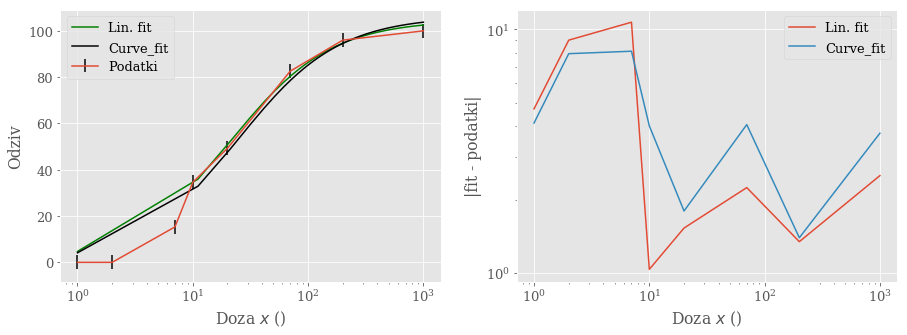

In [119]:
razpon = np.linspace(np.min(data.x), np.max(data.x), num=100)
fit1 = model(razpon, 104.6831033, 21.18935)
fit2 = model(razpon, *popt)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.errorbar(data.x, data.y, yerr=data.y_err, label="Podatki", ecolor="k")
plt.plot(razpon, fit1, label="Lin. fit", c="g")
plt.plot(razpon, fit2, label="Curve_fit", c = "k")
plt.legend()
plt.xlabel(r"Doza $x$ ()")
plt.ylabel(r"Odziv")
plt.semilogx()

plt.subplot(122)
plt.plot(data.x, np.abs(data.y-model(data.x, 104.6831033, 21.18935)), label="Lin. fit")
plt.plot(data.x, np.abs(data.y-model(data.x, *popt)), label="Curve_fit")
plt.semilogy()
plt.semilogx()

plt.ylabel("|fit - podatki|")
plt.xlabel(r"Doza $x$ ()")

plt.legend()
plt.savefig("1-4-primerjavafitov.pdf")
plt.savefig("1-4-primerjavafitov.jpg")
plt.show()

In [117]:
#Hi2 za curve_fit
((data.y-model(data.x, 106, 24))**2 )/ data.y_err

0     5.992251
1    22.156300
2    24.857194
3     3.906851
4     0.416777
5     4.474550
6     0.613946
7     4.119873
dtype: float64

In [112]:
popt

array([106.31712844,  24.76258099])